# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import pandas as pd
import shap

# Reading data and pre-processing

In [3]:
# loading csv
df = pd.read_csv('data/fpl_fbref_elo_lstm.csv')

In [4]:
# removing unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.columns

Index(['Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad', 'Opponent', 'Start',
       'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'Prog', 'Succ', 'Att.1', 'Match Report', 'Name',
       'Season', 'WDL', 'GoalsTeams', 'Team Score', 'Opp Score', 'CS',
       'Was Home', 'GW', 'FPL', 'neutral_name', 'Total Points', 'Opp rating',
       'LSTM'],
      dtype='object')

In [6]:
# dropping NaNs
# df = df.dropna(axis=0)

In [7]:
# df[df["Name"] == "Mohamed-Salah"]

# Adding new features

In [8]:
# average goals for and against team in last 5 matches
grouped = df.groupby('Name')

In [9]:
df['ScoreForLast5'] = grouped['Team Score'].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)

In [10]:
df['ScoreAgainstLast5'] = grouped['Opp Score'].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)

In [11]:
df['ScoreForLast5'] = df['ScoreForLast5'].shift(1)
df['ScoreAgainstLast5'] = df['ScoreAgainstLast5'].shift(1)

In [12]:
df[df["Name"] == "Mohamed-Salah"][["ScoreForLast5", "ScoreAgainstLast5", "Team Score", "Opp Score"]]

,ScoreForLast5,ScoreAgainstLast5,Team Score,Opp Score
4822,2.0,0.60,1,2
4823,1.0,2.00,9,0
4824,5.0,1.00,2,1
4825,4.0,1.00,0,0
4826,3.0,0.75,3,3
4827,3.0,1.20,2,3
4828,3.2,1.40,1,0
4829,1.6,1.40,1,0
4830,1.4,1.20,0,1
4831,1.4,1.40,1,2


# Choosing features and splitting data

In [13]:
features = ["LSTM", "Was Home", "Opp rating", 'ScoreForLast5', 'ScoreAgainstLast5']
info = ["Name", "GW", "Squad", "Opponent", "Was Home", "Opp rating"]
to_predict = ["FPL"]

In [14]:
# gameweeks 9-14 is training data, gw 15 is test data
X_train = df[(df["GW"] >= 9) & (df["GW"] <= 14)][features]
y_train = df[(df["GW"] >= 9) & (df["GW"] <= 14)][to_predict]

In [15]:
X_test = df[df["GW"] == 15][features]
y_test = df[df["GW"] == 15][to_predict]

# Model

In [16]:
model = xgb.XGBRegressor()

In [17]:
%%time
model.fit(X_train, y_train)

CPU times: total: 703 ms
Wall time: 185 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [18]:
# make predictions on the test data
predictions = model.predict(X_test)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# calculate the MAE and MSE scores
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

In [20]:
print("MAE: ", mae)
print("MSE: ", mse)

MAE:  1.3119101382891336
MSE:  4.093980438396579


# Predictions

In [21]:
X_test = df[df["GW"] == 15][features]
y_test = df[df["GW"] == 15][to_predict]

In [22]:
df_predictions = df[df["GW"] == 15]

In [23]:
df_predictions.shape

(375, 50)

In [24]:
len(predictions)

375

In [25]:
df_predictions["pred"] = predictions


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
model.predict(df[df["GW"] == 15][df["Name"] == "Mohamed-Salah"][features])

Boolean Series key will be reindexed to match DataFrame index.


array([3.436843], dtype=float32)

In [27]:
df_predictions[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,FPL,pred
2382,Erling-Haaland,15,Manchester City,Fulham,1.0,1685.670776,6.0,9.769238
2868,Harry-Kane,15,Tottenham,Liverpool,1.0,1991.513672,7.0,7.406974
618,Said-Benrahma,15,West Ham,Crystal Palace,1.0,1764.660889,7.0,6.962663
1378,Kevin-De-Bruyne,15,Manchester City,Fulham,1.0,1685.670776,2.0,6.116436
4573,Declan-Rice,15,West Ham,Crystal Palace,1.0,1764.660889,2.0,6.010484
3963,Vitaliy-Mykolenko,15,Everton,Leicester City,1.0,1760.568481,2.0,5.809851
4690,Rodri,15,Manchester City,Fulham,1.0,1685.670776,2.0,5.802184
3218,Keane-Lewis-Potter,15,Brentford,Nott'ham Forest,0.0,1617.486084,1.0,5.683455
3314,Sean-Longstaff,15,Newcastle Utd,Southampton,0.0,1684.680908,2.0,5.497601
5890,Joe-Willock,15,Newcastle Utd,Southampton,0.0,1684.680908,7.0,5.366955


# Feature importance and influence

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

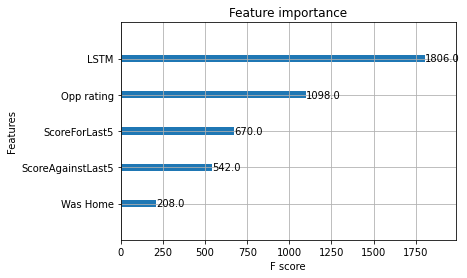

In [28]:
plot_importance(model)

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


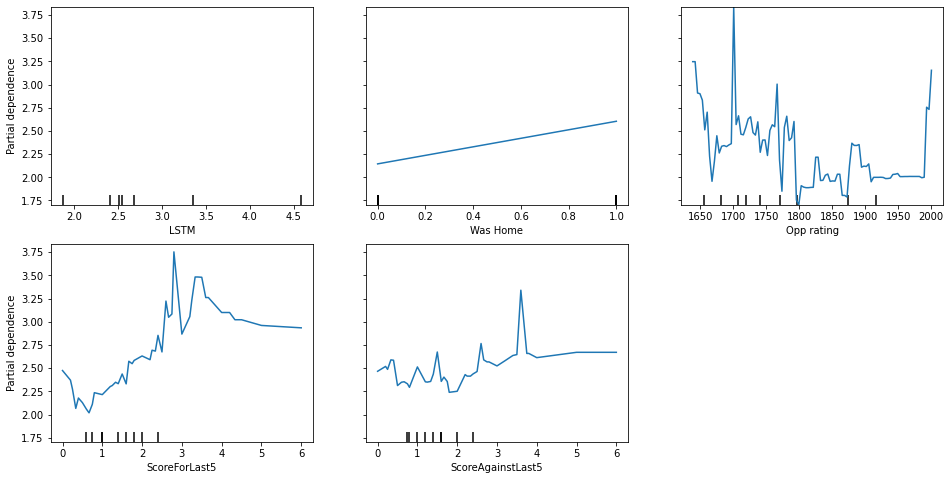

In [29]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_partial_dependence(model, X_train, features, ax=ax)

In [30]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

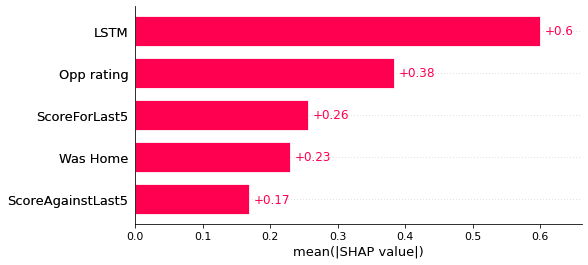

In [31]:
shap.plots.bar(shap_values)

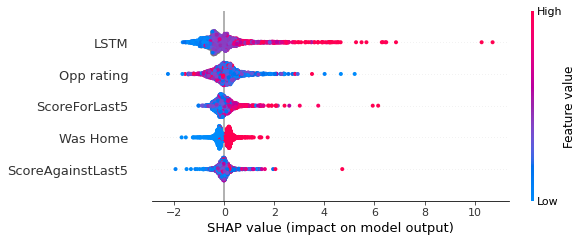

In [32]:
shap.plots.beeswarm(shap_values)